# Load libraries and classes

In [185]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
import json
import glob
import dill
import os

pp = pprint.PrettyPrinter(indent=4)


class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """

    def default(self, obj):
        if isinstance(obj,
                      (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32,
                       np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray, )):  #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


class dataObject:
    """"""

    def __init__(self, parameters, filename):
        self.populations = []
        self.scores = []
        self.iScores = []
        self.wins = []
        self.filename = filename
        self.parameters = parameters

    def addRep(self, population, scores, iScores, wins):
        self.populations.append(population)
        self.scores.append(scores)
        self.iScores.append(iScores)
        self.wins.append(wins)

    def addMoreRepsClasses(self, other):
        pCheckSelf = json.dumps(
            self.parameters, cls=NumpyEncoder, sort_keys=True)
        pcheckOther = json.dumps(
            other.parameters, cls=NumpyEncoder, sort_keys=True)
        assert pCheckSelf == pcheckOther, "Not same parameters"

        self.populations += other.populations
        self.scores += other.scores
        self.iScores += other.iScores
        self.wins += other.wins

    def load(self):
        f = open(self.filename, 'rb')
        tmp_dict = dill.load(f)
        f.close()
        self.__dict__.clear()
        self.__dict__.update(tmp_dict)

    def save(self):
        f = open(self.filename, 'wb')
        dill.dump(self.__dict__, f, 2)
        f.close()

    def calcScore(self):
        return np.max(self.scores[-1])


def prettyfie(ax, x, y, title, legendYN="Yes"):

    # Remove borders
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(alpha=0.25)

    # Remove unnecessary ticks
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)

    if legendYN == "Yes":
        # Create legend and grid
        ax.legend(framealpha=1, shadow=True)
        ax.legend()

    # Set labels and title
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Group output pickles

As all 10 repetitions are not necessarily run in one go, this groups them together by their trial names

In [179]:
groups = {}

for filename in glob.glob('data/bas/*.pkl'):
    basename, extension = os.path.splitext(filename)
    project, _, gens, _, psize, *_ = basename.split('_')
    project = project.split('\\')[-1]
    groups.setdefault(project, [])
    groups[project].append(filename)

pp.pprint(groups)

{   'allENEMIES': [   'data/bas\\allENEMIES_gens_50_psize_100_2019_10_13_21_35_50.pkl',
                      'data/bas\\allENEMIES_gens_50_psize_100_2019_10_13_21_35_56.pkl'],
    'rand4ENEMIES': [   'data/bas\\rand4ENEMIES_gens_50_psize_100_2019_10_13_22_03_38.pkl',
                        'data/bas\\rand4ENEMIES_gens_50_psize_100_2019_10_13_22_03_44.pkl']}


# Append grouped data in single instance

Also check whether appending has worked and check maximum number of wins

In [206]:
allData = {}

for group in groups:
    firstData = dataObject("", groups[group][0])
    firstData.load()
    allData.setdefault(group, firstData)
    for i in range(len(groups[group])-1):
        dataTMP = dataObject("", groups[group][i+1])
        dataTMP.load()
        dataTMP.parameters
        allData[group].addMoreRepsClasses(dataTMP)
    
    maxWins = np.max([[np.max(i) for i in j] for j in allData[group].wins])
    print(f"{group} has {len(allData[group].scores)} repetitions in total with max wins of {maxWins}")

allENEMIES has 10 repetitions in total with max wins of 5
rand4ENEMIES has 10 repetitions in total with max wins of 4


# Check if latest and best solution works and wins 
By running simulation on the best parameter set, we can see if everything worked as expected

In [182]:
import sys, os
sys.path.insert(0, 'evoman') 
from environment import Environment
from demo_controller import player_controller

experiment_name = 'dummy_demo'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)
    

for trialName in allData:
    print(trialName)
    m = np.argmax(allData[trialName].scores[0][-1])

    # initializes environment with ai player using random controller, playing against static enemy
    env = Environment(
            experiment_name=experiment_name,
            enemies=[1],
            playermode="ai",
            player_controller=player_controller(),
            enemymode="static",
            level=2,
            speed="fastest")

    env.player_controller.n_hidden = [10]
    enemyFighters = list(range(1,9))
    for en in enemyFighters:
        env.update_parameter('enemies', [en])
        print(env.play(pcont=allData[trialName].populations[0][-1][m]))


allENEMIES
(12.790513847158579, 0, 80.0, 183)
(88.20278772623588, 32, 0, 148)
(30.918595635015535, 0, 60.0, 161)
(30.531939858864867, 0, 60.0, 237)
(88.68324619773175, 43.60000000000029, 0, 292)
(86.18835394814498, 16.000000000000227, 0, 224)
(84.45794861721986, 2.200000000000234, 0, 318)
(86.33574420258549, 22.600000000000243, 0, 374)
rand4ENEMIES
(-5.25227342804663, 0, 100, 191)
(87.72700044143625, 30, 0, 195)
(4.31786877287578, 0, 90.0, 108)
(3.6018372984822475, 0, 90.0, 221)
(2.699214205336756, 0, 90.0, 545)
(-5.267858159063328, 0, 100, 194)
(57.03642065638155, 0, 30.0, 389)
(86.12628484395722, 21.40000000000024, 0, 409)


# Plot results

allENEMIES
General scores mean


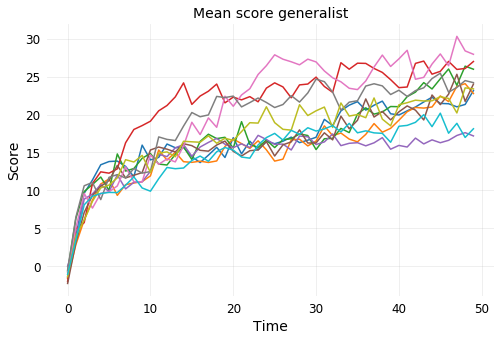

General scores max


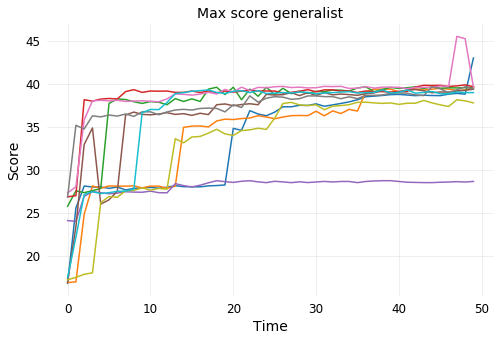

Specialist score over generatie beste score


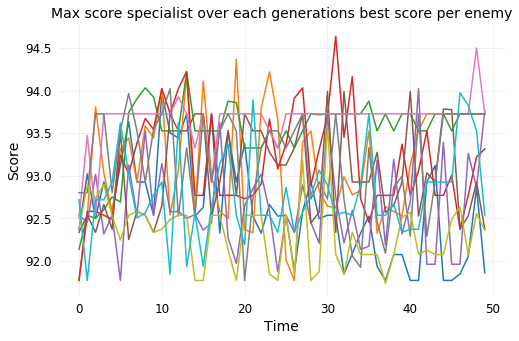

Specialist score per enemy beste score


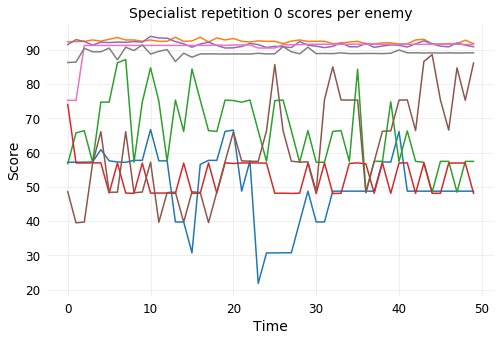

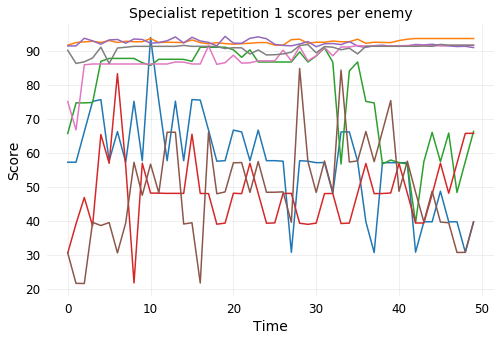

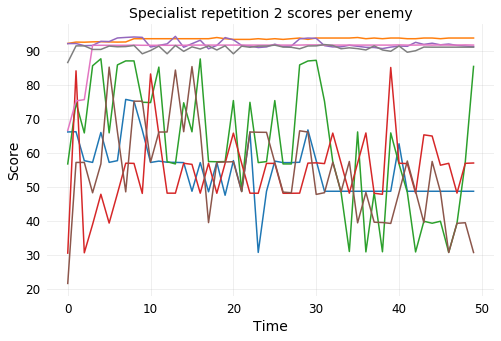

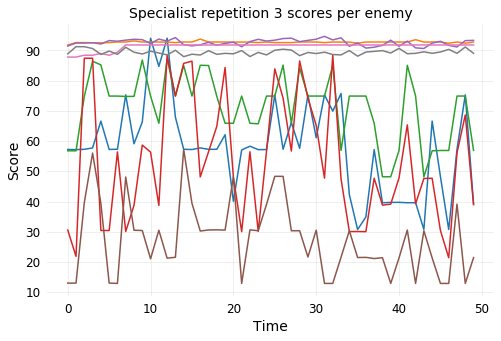

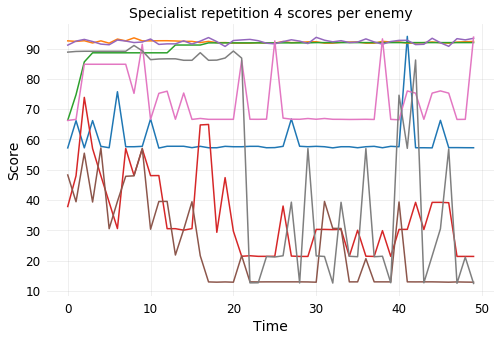

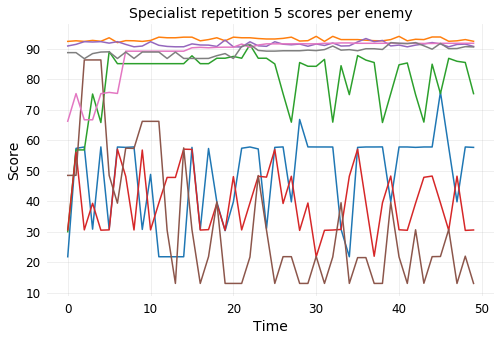

In [ ]:
for trialName in allData:
    print(trialName)
    print("General scores mean")
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    for rep in range(len(allData[trialName].scores)):
        gens = [
            np.mean(generation)
            for generation in allData[trialName].scores[rep]
        ]
        ax.plot(gens)
    prettyfie(ax, "Time", "Score", "Mean score generalist", legendYN="No")
    plt.savefig(f"img/bas/meanScoreGeneralist_{trialName}.png")
    plt.show()

    print("General scores max")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    for rep in range(len(allData[trialName].scores)):
        gensMax = [
            np.max(generation) for generation in allData[trialName].scores[rep]
        ]
        ax.plot(gensMax)
    prettyfie(ax, "Time", "Score", "Max score generalist", legendYN="No")
    plt.savefig(f"img/bas/maxScoreGeneralist_{trialName}.png")
    plt.show()

    print("Specialist score over generatie beste score")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    for rep in range(len(allData[trialName].scores)):
        gensMax = [
            np.max(generation)
            for generation in allData[trialName].iScores[rep]
        ]
        ax.plot(gensMax)
    prettyfie(
        ax,
        "Time",
        "Score",
        "Max score specialist over each generations best score per enemy",
        legendYN="No")
    plt.savefig(f"img/bas/maxScoreSpecialist_{trialName}.png")
    plt.show()

    print("Specialist score per enemy beste score")
    for rep in range(len(allData[trialName].scores)):
        enemyScores = np.array([
            np.max(np.array(d), axis=0)
            for d in allData[trialName].iScores[rep]
        ])
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(enemyScores)
        prettyfie(
            ax,
            "Time",
            "Score",
            f"Specialist repetition {rep} scores per enemy",
            legendYN="No")
        plt.savefig(f"img/bas/scoreSpecialist_rep_{rep}_{trialName}.png")
        plt.show()